# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Lab 3: 18-Sep-2020, Friday
## N-Gram Language Models

In [1]:
# !conda install -c conda-forge jsonlines #OR
!pip install jsonlines

In [2]:
# Import required packages
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import defaultdict
from pprint import pprint
import jsonlines
import matplotlib.pyplot as plt
from itertools import product

# Set random seed
np.random.seed(1011)

cf.
> `pprint` Prints (“pretty-print”) the formatted representation of object followed by a newline.

> [`defaultdict`](https://docs.python.org/3.7/library/collections.html#collections.defaultdict) a subclass of the built-in `dict` class that makes it simpler and faster to create dictionary of iterables

> [`jsonlines`](https://pypi.org/project/jsonlines/) library to simplify working with JSON Lines text (newline-delimited JSON) format

> [`matplotlib`](https://matplotlib.org/3.3.1/index.html) visualization library for Python. `pyplot` provides simple interface for generating interactive plot programmaticaly

> [`itertools`](https://docs.python.org/3.7/library/itertools.html) module for implementing objects representing stream of data ($\texttt{iterator}$). `product` results in a cartesian product of input iterables.

---
### N-gram Language Modeling

Recall that we want to model the probability of variable length sequences, $$p(w_1,\ldots,w_T)=\prod_{t=1}^T p(w_t|w_{<t}).$$

An **n-gram language model** assumes that each word $w_t$ only depends on the preceding $n-1$ words, $$p(w_1,\ldots,w_T)=\prod_{t=1}^T p(w_t|w_{t-n+1},\ldots,w_{t-1}).$$

We will abbreviate the preceding $n-1$ words as $w_{t-n+1}^{t-1}$. 

#### Example
For instance, when modeling the sentence $$\texttt{the cat sat on the mat .}$$ a 3-gram language model assumes that $$p(\texttt{mat}|\texttt{the cat sat on the}) \approx p(\texttt{mat}|\texttt{on the}).$$

The sub-sequence $(\texttt{on the mat})$ is a *3-gram* or *trigram*.

#### Estimation

Given some dataset $D$ of sequences, we can estimate an n-gram model through counting, derived as follows:

\begin{align}
p(w_t|w_{t-n+1},\ldots,w_{t-1}) &= \frac{p(w_{t-n+1},\ldots,w_t)}{p(w_{t-n+1},\ldots,w_{t-1})} & \text{definition of conditional probability}\\
                       &= \frac{p(w_{t-n+1},\ldots,w_t)}{\sum_{w_{t'}}p(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &\approx \frac{\frac{1}{N}\text{count}(w_{t-n+1},\ldots,w_t)}{\frac{1}{N}\sum_{w_{t'}}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &= \frac{\text{count}(w_{t-n+1},\ldots,w_t)}{\sum_{w_{t'}}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &= \frac{\text{count}(w_{t-n+1},\ldots,w_t)}{\text{count}(w_{t-n+1},\ldots,w_{t-1})},
\end{align}

where $N$ is the number of $n$-grams in the dataset.

In Python, we can collect these counts into a dictionary mapping a prefix to a dictionary of counts:

        count[(w_n+1,...,w_t-1)] = {wt1: count of (w_n+1,...,w_t1),
                                    wt2: count of (w_n+1,...,w_t2),
                                    ...
                                   }
                                   
and for the denominator, maintain a dictionary of totals:

        total[(w_n+1,...,w_t-1)] = count of w_n+1,...,w_t-1

---
### Simplified Language

To get intuition, lets start by modeling a simple language called `ABC`. A word in this language is one of three tokens, $$w\in \{\texttt{A, B, C}\},$$
and we'll denote a sentence as $\textbf{s}=(w_1,\ldots,w_{|\textbf{w}|})$.


Suppose we are given the following dataset, and want to estimate a **bigram model**: $$p(\textbf{s})\approx\prod_{t=1}^{|\textbf{w}|}p(w_t|w_{t-1})$$

In [3]:
data_raw = [['A', 'A', 'B', 'B'],
            ['A', 'A', 'B'],
            ['A', 'A', 'B', 'C'],
            ['A', 'A', 'A'],
            ['A', 'A', 'A', 'A']]

To make the model meaningful for $t = 1$ we pad the sentences with an additional **beginning token**, `<bos>`. 

Since our model is a probability distribution, the total probability of all possible strings in the language must sum to 1, i.e.: $$\sum_{\textbf{s}}p(\textbf{s})=1.$$

In order to satisfy this criterion we need an additional **end token**, `<eos>`.

In [4]:
data = [['<bos>'] + d + ['<eos>'] for d in data_raw]
data

[['<bos>', 'A', 'A', 'B', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', 'C', '<eos>'],
 ['<bos>', 'A', 'A', 'A', '<eos>'],
 ['<bos>', 'A', 'A', 'A', 'A', '<eos>']]

Now let's estimate a bigram model:

\begin{align}
p(w_t|w_{t-1}) &= \frac{\text{count}(w_{t-1}w_{t})}{\sum_{w_{t'}}\text{count}(w_{t-1}w_{t'})}\\
               &= \texttt{count[prefix][wt] / totals[prefix]}
\end{align} 

where $\texttt{prefix}$ is $w_{t-1}$ in this case.

In [5]:
count = defaultdict(lambda: defaultdict(float))
total = defaultdict(float)

n = 2
for sequence in data:
    for i in range(len(sequence)-n+1):         # for each ngram
        ngram = tuple(sequence[i:i+n])
        prefix, word = ngram[:-1], ngram[-1]
        count[prefix][word] += 1               # count(w_{t-n+1}...w_t)
        total[prefix] += 1                     # count(w_{t-n+1}...w_{t-1})

cf.
> `lambda` lambda expressions (or forms) are used to create anonymous functions. The expression `lambda parameters: expression` yields a function object.

Let's see if the counts and totals make sense:

- How many times did (A, B) occur? What about (B, B)?
- How many times did (A) occur? What about (C)?

In [6]:
print("Counts:")
print(dict(count))
print("\nTotals:")
print(dict(total))

Counts:
{('<bos>',): defaultdict(<class 'float'>, {'A': 5.0}), ('A',): defaultdict(<class 'float'>, {'A': 8.0, 'B': 3.0, '<eos>': 2.0}), ('B',): defaultdict(<class 'float'>, {'B': 1.0, '<eos>': 2.0, 'C': 1.0}), ('C',): defaultdict(<class 'float'>, {'<eos>': 1.0})}

Totals:
{('<bos>',): 5.0, ('A',): 13.0, ('B',): 4.0, ('C',): 1.0}


#### Conditional probability queries

We can now query a conditional probability:

\begin{align}
\texttt{p(word|prefix)} &= \texttt{count[prefix][word] / totals[prefix]}
\end{align}

In [7]:
queries = [('<bos>', 'A'),
           ('B', 'C')]

for query in queries:
    prefix, word = query[:-1], query[-1]
    p = count[prefix][word] / total[prefix]  # We'll discuss the case when `total[prefix] = 0` below.
    print("p( %s | %s) = \t%.5f" % (word, ', '.join(prefix), p))

p( A | <bos>) = 	1.00000
p( C | B) = 	0.25000


**Exercise**: Look at the training set and convince yourself that these conditional probabilities are correct according to the count-based estimation procedure.

#### Sequence Probability

We can compute the probability of a sequence using the conditional probabilities along with the chain rule:

\begin{align}
p(w_1,\ldots,w_T)&\approx\prod_{t=1}^T p(w_t|w_{t-1})
\end{align}

(Here $w_0$ is `<bos>` and $w_T$ is `<eos>`)

In [8]:
sequence = ['<bos>', 'A', 'A', 'B', '<eos>']

def sequence_p(sequence, log=False):
    total_p = 1

    for i in range(len(sequence)-n+1):
        ngram = tuple(sequence[i:i+n])
        prefix = ngram[:-1]
        word = ngram[-1]
        p = count[prefix][word] / max(total[prefix], 1)
        if log:
            print("p(%s | %s) =\t%.3f" % (word, ', '.join(prefix), p))

        total_p *= p
    return total_p
    

print("\nProduct: p(%s) = %.3f" % (''.join(sequence[1:-1]), sequence_p(sequence, log=True)))

p(A | <bos>) =	1.000
p(A | A) =	0.615
p(B | A) =	0.231
p(<eos> | B) =	0.500

Product: p(AAB) = 0.071


---
### Real Example: Dialogue Utterances

Now lets use the same ideas on a more realistic text corpus.

We will use utterances from a dialogue dataset called **Persona-Chat**. This dataset is relatively small and centers on a single domain, but it is simple and interpretable for our purposes here.

#### Loading the dataset

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
path = "/content/drive/My Drive/NLP Lab/Lab 3/"

In [21]:
train = []
val = []

for ds, name in [(train, 'train'), (val, 'valid')]:
    for line in jsonlines.Reader(open(path+'data/personachat/personachat_all_sentences_%s.jsonl' % name, 'r')):
        ds.append(line['tokens'])
        
vocab = list(set([t for ts in train for t in ts]))      
print("Number of train examples: %d" % (len(train)))
print("Number of valid examples: %d" % (len(val)))
print("Vocab size: %d" % (len(vocab)))

print("\nExamples:")
pprint(train[:3])

Number of train examples: 133176
Number of valid examples: 16181
Vocab size: 19153

Examples:
[['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.'],
 ['i', 'am', 'a', 'woman', 'what', 'about', 'you', '.'],
 ['i', 'thought', 'you', 'were', 'a', 'college', 'kid', '.']]


#### Estimate a **3-gram** model

We will use the same approach as in the `ABC` example, except for a 3-gram model.

Notice that we now prepend 2 `<bos>` tokens, so that the first conditional probability is `p(first_word|<bos>, <bos>)`.

In [22]:
count = defaultdict(lambda: defaultdict(float))
total = defaultdict(float)

n = 3

for sequence_raw in train:
    sequence = ['<bos>']*(n-1) + sequence_raw + ['<eos>']
    for i in range(len(sequence)-n+1):
        ngram = tuple(sequence[i:i+n])
        prefix, word = ngram[:-1], ngram[-1]

        count[prefix][word] += 1
        total[prefix] += 1

#### Counts

Let's check some of the counts for a few trigrams, by querying bigrams and finding the next-words with the highest counts:

In [23]:
bigram = ('i', 'have')
limit = 10

for w, c in sorted(count[bigram].items(), key=lambda x: -x[1])[:limit]:
    print("(%s, %s, %s) -> %.1f" % (bigram[0], bigram[1], w, c))

(i, have, a) -> 2092.0
(i, have, been) -> 740.0
(i, have, to) -> 567.0
(i, have, never) -> 531.0
(i, have, not) -> 484.0
(i, have, two) -> 335.0
(i, have, no) -> 191.0
(i, have, 2) -> 175.0
(i, have, 3) -> 163.0
(i, have, one) -> 161.0


**Exercise:** How many times does `my pet dog` occur in the training set? What about `my pet lion`?

In [24]:
count[('my', 'pet')]

defaultdict(float,
            {'.': 6.0,
             '?': 1.0,
             'and': 2.0,
             'bear': 1.0,
             'beta': 2.0,
             'cat': 3.0,
             'dog': 2.0,
             'dogs': 2.0,
             'dragon': 1.0,
             'iguana': 8.0,
             'iguanas': 4.0,
             'is': 3.0,
             'keeps': 1.0,
             'koala': 1.0,
             'like': 1.0,
             'lizard': 8.0,
             'on': 1.0,
             'panda': 3.0,
             'poodle': 1.0,
             'skunk': 5.0,
             'snake': 7.0,
             'turtles': 1.0,
             'was': 1.0,
             'zebra': 1.0})

In [25]:
bigram = ('my', 'pet')
limit = 15

for w, c in sorted(count[bigram].items(), key=lambda x: x[1])[:limit]:
    print("(%s, %s, %s) -> %.1f" % (bigram[0], bigram[1], w, c))

(my, pet, on) -> 1.0
(my, pet, like) -> 1.0
(my, pet, zebra) -> 1.0
(my, pet, was) -> 1.0
(my, pet, poodle) -> 1.0
(my, pet, turtles) -> 1.0
(my, pet, ?) -> 1.0
(my, pet, dragon) -> 1.0
(my, pet, keeps) -> 1.0
(my, pet, bear) -> 1.0
(my, pet, koala) -> 1.0
(my, pet, dog) -> 2.0
(my, pet, dogs) -> 2.0
(my, pet, and) -> 2.0
(my, pet, beta) -> 2.0


#### Conditional probability queries
We can now query the model for conditional probabilities:

\begin{align}
p(w_t|w_{t-2},w_{t-1}) &= \frac{\text{count}(w_{t-2}w_{t-1}w_t)}{\sum_{w_{t'}}\text{count}(w_{t-2}w_{t-1}w_{t'})},
\end{align} 

In [26]:
total[('i', 'have')]

9034.0

In [27]:
queries = [('i', 'have', 'a'),
           ('i', 'have', 'no'),
           ('my', 'name', 'is'),
           ('my', 'pet', 'dog'),
           ('my', 'pet', 'zebra'),
           ('my', 'pet', 'lion')]

for query in queries:
    prefix, word = query[:-1], query[-1]
    p = count[prefix][word] / max(total[prefix], 1)
    print("p( %s | %s) = \t%.5f" % (word, ', '.join(prefix), p))

p( a | i, have) = 	0.23157
p( no | i, have) = 	0.02114
p( is | my, name) = 	0.93409
p( dog | my, pet) = 	0.03030
p( zebra | my, pet) = 	0.01515
p( lion | my, pet) = 	0.00000


#### Sequence probabilities:
\begin{align}
p(w_1,\ldots,w_T)&\approx\prod_{t=1}^T p(w_t|w_{t-2},w_{t-1})\\
&=\sum_{t=1}^T \log p(w_t|w_{t-2},w_{t-1}).
\end{align}

where we use log probabilities in practice to avoid a product of many small numbers.

In [28]:
padded_sequence = ['<bos>']*(n-1) + train[0] + ['<eos>']
print(padded_sequence)

['<bos>', '<bos>', 'i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.', '<eos>']


In [29]:
total_logp = 0

for i in range(len(padded_sequence)-n+1):
    ngram = tuple(padded_sequence[i:i+n])
    prefix = ngram[:-1]
    word = ngram[-1]
    logp = np.log2(count[prefix][word] / max(total[prefix], 1))
    print("log p(%s | %s) =\t%.3f" % (word, ', '.join(prefix), logp))
    
    total_logp += logp
    
print("\nTotal: %.3f" % total_logp)

log p(i | <bos>, <bos>) =	-1.631
log p(am | <bos>, i) =	-1.969
log p(doing | i, am) =	-4.455
log p(great | am, doing) =	-2.359
log p(except | doing, great) =	-8.205
log p(for | great, except) =	0.000
log p(the | except, for) =	-2.644
log p(allergies | for, the) =	-9.671
log p(. | the, allergies) =	-0.415
log p(<eos> | allergies, .) =	-0.363

Total: -31.710


**Exercise**: Which conditional probability above has the highest probability?

#### Generation

Finally, we can generate sentences using the model's conditional distribution:

            context = [<bos>, <bos>]
            until <eos> is generated:
                wt ~ p(wt | context)
                context += [wt]
                
                
Here, the `~` symbol stands for sampling from a categorical distribution. 

In [30]:
for n_samples in range(10):
    context = ('<bos>', '<bos>')

    output = context
    while output[-1] != '<eos>':
        # Form conditional distribution to sample from
        probs, tokens = [], []
        for token in count[context]:
            p = count[context][token] / total[context]
            probs.append(p)
            tokens.append(token)
        # Sample
        wt = np.random.choice(tokens, p=probs) # randomly sample from list (tokens) with probs
        output = output + (wt,)
        context = context[1:] + (wt,)
    
    print(' '.join(output))

<bos> <bos> my wife was in africa . now . t . have you tried using a racket and ball game . <eos>
<bos> <bos> not sure yet . <eos>
<bos> <bos> i am a nurse . <eos>
<bos> <bos> i ride my bike , that feels . i am guessing you are not you take with me . <eos>
<bos> <bos> i travelled the world . <eos>
<bos> <bos> interesting ? <eos>
<bos> <bos> it is a boy and girl . <eos>
<bos> <bos> i like to play board games a lot mostly poems . <eos>
<bos> <bos> i like rocks ? <eos>
<bos> <bos> hey , good , i could , i wish i can see that from your mother ? that sounds nice but i do anymore . <eos>


**Exercise:** Try different starting contexts.

**Exercise:** Use **greedy** decoding, `wt = argmax p(wt | context)`, or another decoding method instead of the categorical sampling from above.

---
### 🚨Issues: Data Sparsity & Generalization 🚨

As you might have noticed, the model assigns zero probability to even some reasonable n-grams:

In [31]:
queries = [('my', 'pet', 'dog'),
           ('my', 'pet', 'zebra'),
           ('my', 'pet', 'lion')]

for query in queries:
    prefix, word = query[:-1], query[-1]
    p = count[prefix][word] / max(total[prefix], 1)
    print("p( %s | %s) = \t%.5f" % (word, ', '.join(prefix), p))

p( dog | my, pet) = 	0.03030
p( zebra | my, pet) = 	0.01515
p( lion | my, pet) = 	0.00000


In [32]:
count[('my', 'pet')][('<UNK>')]

0.0

The tri-gram `my pet lion` never occurred in the corpus, corresponding to zero count and hence zero probability under the model.

This is in part an issue of **data sparsity** (given infinite data we'd probably see `my pet lion`), but is also an instance of the **generalization** problem; intuitively, even though the model *has* seen `my pet dog` and `my pet zebra`, it does not form a general notion of `my pet {animal}`.

#### Additive smoothing

N-gram language models address data sparsity through **smoothing** techniques which re-allocate probability mass, for instance to n-grams with zero counts.

A simple (and naive, according to empirical performance) smoothing method is to add a *fixed* 'pseudo-count' $\delta$ to *every* n-gram:
\begin{align}
p(w_t|w_{t-n+1},\ldots,w_{t-1}) &\approx \frac{\text{count}(w_{t-n+1},\ldots,w_{t})+ \delta}{\sum_{w_{t'}}\left[\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})+\delta\right]}\\
&= \frac{\text{count}(w_{t-n+1},\ldots,w_{t})+ \delta}{\delta|V| + \sum_{w_{t'}}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})},
\end{align}

where V is the vocabulary.

Let's implement this below:

In [33]:
delta = 0.01
Vsize = len(vocab)

queries = [('my', 'pet', 'dog'),
           ('my', 'pet', 'zebra'),
           ('my', 'pet', 'lion')]

for query in queries:
    prefix, word = query[:-1], query[-1]
    
    ### note the ADDITIVE SMOOTHING ↓
    p = (delta + count[prefix][word]) / (total[prefix] + delta*Vsize)
    
    print("p( %s | %s) = \t%.5f" % (word, ', '.join(prefix), p))

p( dog | my, pet) = 	0.00780
p( zebra | my, pet) = 	0.00392
p( lion | my, pet) = 	0.00004


**Exercise:** How does `p(lion | my, pet)` change as $\delta$ decreases/increases? What about `p(dog | my, pet)`?

---
### Evaluation

#### Perplexity

Intuitively, a good model should assign high probabilities to sequences from the 'true' distribution that it is modeling.

A common way of quantifying this is with **perplexity**, a metric inversely-proportional to the probability that the model assigns to a set of sequences, e.g. a 'test set':

\begin{align}
\huge \text{ppl}(p, D) &\huge = -\frac{1}{N_{total}}\log p(D)
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

Intuitively, when measured in exponential form, **_perplexity measures the average rank of the true next-token, when tokens are ordered by the model's conditional probabilities_**. It is defined on $[1,\infty)$, with 1 being a perfect model (assigning probability 1 to $D$), and a 'worse' model as perplexity increases.

#### Evaluating our model (and variations)

To allow for adjusting $n$ and $\delta$, let's first put the n-gram model estimation and querying from above into a python class:

In [34]:
class NGramLM(object):
    def __init__(self, n, delta, vocab):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vocab = vocab
        if '<eos>' not in self.vocab:
            self.vocab.append('<eos>')
        self.vsize = len(vocab)
    
    def estimate(self, sequences):
        for sequence_raw in sequences:
            sequence = ['<bos>']*(self.n-1) + sequence_raw + ['<eos>']
            for i in range(len(sequence)-self.n+1):
                ngram = tuple(sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence_raw):
        sequence = ['<bos>']*(self.n-1) + sequence_raw + ['<eos>']
        total_logp = 0
        for i in range(len(sequence)-self.n+1):
            ngram = tuple(sequence[i:i+self.n])
            prefix = ngram[:-1]
            word = ngram[-1]
            logp = np.log2((self.delta + self.count[prefix][word]) / 
                           (self.total[prefix] + self.delta*self.vsize))
            total_logp += logp
        return total_logp

In [35]:
lm = NGramLM(n=3, delta=0.0001, vocab=vocab)
lm.estimate(train)
print(lm.sequence_logp(train[0]))

-33.158200479259946


Next we'll define a `perplexity` function:

In [36]:
def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1             # add 1 for <eos>
#     ppl = - (1.0 / n_total) * logp_total
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  # the log needs to be in base 2!
    return ppl

In [37]:
print(perplexity(lm, [['i', 'have', 'a', 'dog', '.']]))

print(perplexity(lm, [['i', 'have', 'a', 'zebra', '.']]))

print(perplexity(lm, [['i', 'have', 'a', 'lion', '.']]))

5.167222880362521
14.307400631227289
54.29411412205784


#### Evaluation

Let's evaluate `train` and `val` perplexity for a range of `n` at a fixed `delta`:

In [38]:
ns = [2, 3, 4]
deltas = [0.0001]

train_results = {}
val_results = {}
lms = {}
combos = list(product(ns, deltas))
for n, d in tqdm(combos, total=len(combos)):
    lm = NGramLM(n=n, delta=d, vocab=vocab)
    lm.estimate(train)
    
    lms[n, d] = lm
    train_results[n, d] = perplexity(lm, train)
    val_results[n, d] = perplexity(lm, val)

100%|██████████| 3/3 [00:27<00:00,  9.05s/it]


In [39]:
ns = [2, 3, 4]
deltas = [0.0001]
list(product(ns, deltas))

[(2, 0.0001), (3, 0.0001), (4, 0.0001)]

In [40]:
print("=== Train ===")
df = pd.DataFrame([(k[0], k[1], v) for k, v in train_results.items()], columns=['n', 'delta', 'ppl'])
df[df.delta == 0.0001].style.hide_index()

=== Train ===


n,delta,ppl
2,0.000100,35.478667
3,0.000100,12.189784
4,0.000100,7.071077


On the **training set**, perplexity **decreased** as n-gram order increased (at a fixed `delta` value).


Now, on the validation set:

In [41]:
print("=== Valid ===")
df = pd.DataFrame([(k[0], k[1], v) for k, v in val_results.items()], columns=['n', 'd', 'ppl'])
df[df.d == 0.0001].style.hide_index()

=== Valid ===


n,d,ppl
2,0.000100,94.251318
3,0.000100,196.977312
4,0.000100,601.984842


Next we can plot **performance as `delta` varies**.

(for efficiency we'll simply modify the `.delta` parameter instead of creating a new model)

In [42]:
ns = [2, 3, 4]
deltas = np.linspace(0.00001, 0.01, 10)

T = np.zeros((len(ns), len(deltas)))
V = np.zeros((len(ns), len(deltas)))

for i, n in tqdm(enumerate(ns), total=len(ns)):
    lm = lms[n, 0.0001]
    for j, delta in enumerate(deltas):
        lm.delta = delta
        
        T[i, j] = perplexity(lm, train)
        V[i, j] = perplexity(lm, val)

100%|██████████| 3/3 [04:02<00:00, 80.71s/it]


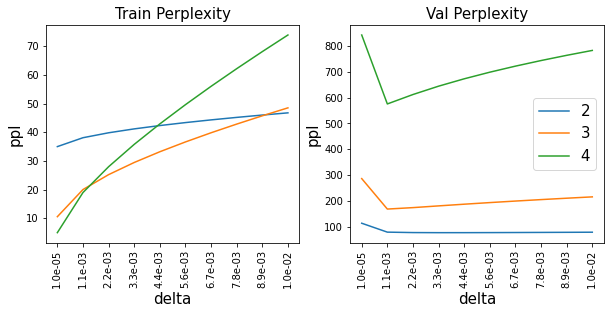

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(len(ns)):
    axs[0].plot(T[i])
    axs[1].plot(V[i])
    
axs[0].set_title("Train Perplexity", fontsize=15)
axs[1].set_title("Val Perplexity", fontsize=15)

axs[0].set_xticks(np.arange(len(deltas)))
axs[1].set_xticks(np.arange(len(deltas)))

axs[0].set_xticklabels(['{:.1e}'.format(x) for x in deltas], rotation=90)
axs[1].set_xticklabels(['{:.1e}'.format(x) for x in deltas], rotation=90)

axs[0].set_xlabel('delta', fontsize=15)
axs[1].set_xlabel('delta', fontsize=15)

axs[0].set_ylabel('ppl', fontsize=15)
axs[1].set_ylabel('ppl', fontsize=15)

plt.legend(ns, fontsize=15);

### Scoring Sentences

In [44]:
sentences = [
    'i like my pet dog .',
    'i like my pet zebra .',
    'i like my pet lion .',
    'i live in the united states .',
    'i live in the united states of america .'
]

for sentence in sentences:
    print(sentence)
    for n in [2, 3, 4]:
        logp = lms[n, 0.0001].sequence_logp(sentence.split())
        print("n: %d\t logp: %.3f" % (n, logp))
    print()

i like my pet dog .
n: 2	 logp: -29.697
n: 3	 logp: -35.726
n: 4	 logp: -54.898

i like my pet zebra .
n: 2	 logp: -34.919
n: 3	 logp: -42.678
n: 4	 logp: -63.110

i like my pet lion .
n: 2	 logp: -40.617
n: 3	 logp: -54.717
n: 4	 logp: -69.753

i live in the united states .
n: 2	 logp: -26.129
n: 3	 logp: -27.717
n: 4	 logp: -29.649

i live in the united states of america .
n: 2	 logp: -44.935
n: 3	 logp: -43.757
n: 4	 logp: -49.340



---
## References
DS-GA 1011 NLP with Representation Learning Fall 2019